In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import os
import tensorflow as tf
import numpy as np
import cv2
import time
import tifffile
import matplotlib.pyplot as plt
!pip install sewar
from PIL import Image
import skimage.measure  
import skimage.measure
import pywt
from math import log10, sqrt
import cv2
import numpy as np
from sewar.full_ref import mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb
from pywt import idwt2

    



  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=07041e2d5f10b225e280d4d9043bc5073c16597bbad93aabc64636a69de485b5
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [3]:
os.getcwd()

'/content'

In [4]:
os.chdir('/content/drive/MyDrive/ProjectWork')

In [5]:

def read8bit(path,name):
    if name=='ms':
        v='src'
    else:
        v='pan'
    v='I'
    #img=scio.loadmat(path)[v]
    img=np.load(path)
    img=(img-127.5)/127.5
    return img
def read_img(pan_test_path, ms_test_path, img_name, FLAGS):
    pan_img_path=os.path.join(pan_test_path, img_name)
    ms_img_path=os.path.join(ms_test_path, img_name)
    #pan_img=cv2.imread(pan_img_path, -1)
    #pan_img=gdal_read(pan_img_path,'pan')
    pan_img=read8bit(pan_img_path,'pan')
    h,w=pan_img.shape
    pan_img=pan_img.reshape((1,h,w,1))
    #ms_img=cv2.imread(ms_img_path, -1)
    #ms_img=gdal_read(ms_img_path,'ms')
    ms_img=read8bit(ms_img_path,'ms')
    h,w,c=ms_img.shape
    ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    h,w,c=ms_img.shape
    
    # ms_img=np.array(ms_img)
    # h,w,c=ms_img.shape
    # ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    ms_img=ms_img.reshape((1,h,w,c))
   
    return pan_img, ms_img

def ssim(m, f):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    m = m.astype(np.float64)
    f = f.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(m, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(f, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(m**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(f**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(m * f, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(m, f):
  '''calculate SSIM
  the same outputs as MATLAB's
  img1, img2: [0, 255]
  '''
  if not m.shape == f.shape:
      raise ValueError('Input images must have the same dimensions.')
  if m.ndim == 2:
      return ssim(m, f)
  elif m.ndim == 3:
      if m.shape[2] == 3:
          ssims = []
          for i in range(3):
              ssims.append(ssim(m, f))
          return np.array(ssims).mean()
      elif m.shape[2] == 1:
          return ssim(np.squeeze(m), np.squeeze(f))
  else:
      raise ValueError('Wrong input image dimensions.')

import math
import numpy as np
import cv2

def ssim(p, f):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    p = p.astype(np.float64)
    f = f.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(p, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(f, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(p**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(f**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(p * f, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(p, f):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not p.shape == f.shape:
        raise ValueError('Input images must have the same dimensions.')
    if p.ndim == 2:
        return ssim(p, f)
    elif m.ndim == 3:
        if p.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(p, f))
            return np.array(ssims).mean()
        elif p.shape[2] == 1:
            return ssim(np.squeeze(p), np.squeeze(f))
    else:
        raise ValueError('Wrong input image dimensions.')




      #@title
from abc import abstractmethod
import numpy as np
from math import pi
from cv2 import cartToPolar, Sobel, CV_32F
from matplotlib.pyplot import imshow, title, show

class XideaPetrovicMetric():
    # xydeas_petrovic parameters
    # The constants Γ, κ , σ  and Γα, κα, σα determine 
    # the  exact  shape  of  the  sigmoid  functions  used  to  form  the  edge  strength  and  
    # orientation  preservation  values.
    def __init__(self, image1, image2, fusedImage) -> None:
        self.EPS = np.finfo(float).eps
        self.GAMMA1 = 1
        self.GAMMA2 = 1
        self.K1 = -10
        self.K2 = -20
        self.DELTA1 = 0.5
        self.DELTA2 = 0.75
        self.L = 1
        self.image1 = image1
        self.image2 = image2
        self.fusedImage = fusedImage

    def _sobel_edge_detection(self, image, verbose=False):
        sx = Sobel(image, CV_32F, 1, 0)
        sy = Sobel(image, CV_32F, 0, 1)

        if verbose:
            imshow(sx, cmap='gray')
            title("Horizontal Edge")
            show()

            imshow(sy, cmap='gray')
            title("Vertical Edge")
            show()

        return cartToPolar(sx, sy)

    def _strenght_n_orientation(self, image):
        #The first input is the source image, which we convert to float. 
        #The second input is the output image, but we'll set that to None as we want the function 
        # call to return that for us. 
        #The third and fourth parameters specify the minimum and maximum values 
        # you want to appear in the output, which is 0 and 1 respectively, 
        #and the last output specifies how you want to normalize the image.
        # What I described falls under the NORM_MINMAX flag.
        #image = normalize(image.astype('float'), None, 0.0, 1.0, NORM_MINMAX)  
        # Kernels for convolving over the images
        #flt1= [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
        #flt2= [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
        # 1) get the map Sobel operator
        #fuseX = filter2D(image, -1, flt1)
        #fuseY = filter2D(image, -1, flt2)
        #   EQUIVALENT TO:
        s_x, s_y = self._sobel_edge_detection(image)
        #fusex
        # A Sobel edge operator is applied to yield the edge strength G
        g = np.sqrt(s_x**2 + s_y**2)
        # Orientation α(n,m) information for each pixel p
        alpha = np.arctan(s_y / ( s_x + self.EPS))
        return (g, alpha)

    def _perceptual_loss(self, gA, gF, alphaA, alphaF):
        # If g o alpha are followed by an underscore are ment to be considered written in uppercase
        # The relative strength and orientation values of g_AF(n,m) and alpha_AF(n,m) of an input 
        # image A with respect to F are formed as:
        
        #x, y = gA.shape
        #g_AF = np.zeros((x,y))
        #for n in range(x):
        #    for m in range(y):
        #        if (gA[n][m]  > gF[n][m]):
        #            g_AF[n][m] = gF[n][m] / ( gA[n][m] + EPS)
        #        else:
        #            g_AF[n][m] = gA[n][m] / ( gF[n][m] + EPS)
        bmap0 = gA > gF
        bmap1 = gA < gF
        
        g_AF0 = np.divide(gF, ( gA + self.EPS))
        g_AF1 = np.divide(gA, ( gF + self.EPS))

        g_AF = np.multiply(bmap0, g_AF0) + np.multiply(bmap1, g_AF1)

        alpha_AF = np.abs( np.abs(alphaA - alphaF) - pi/2) / (pi/2)

        qG_AF = self.GAMMA1 / (1 + np.exp( self.K1 *(g_AF - self.DELTA1)))
        qalpha_AF = self.GAMMA2 / (1 + np.exp( self.K2 *(alpha_AF - self.DELTA2) ))
        # These are used to derive the edge strength and orientation preservation values
        # QgAF(n,m)  and  QαAF(n,m)  model  perceptual  loss  of  information  in  F,  in  terms  of  
        # how well the strength and orientation values of a pixel p(n,m) in A are 
        # represented in the fused image. 
        #
        # Edge  information preservation values are then defined as
        q_AF = qG_AF * qalpha_AF
        # with  0  ≤  Q AF(n,m)  ≤  1 .  A  value  of  0  corresponds  to  the  complete  loss  of  edge  
        # information, at location (n,m), as transferred from A into F. QAF(n,m)=1 indicates 
        # “fusion” from A to F with no loss of information. 
        return q_AF

    def calculate(self):
        # EDGE Strenght and orientation for each pixels of the input images
        gA, alphaA = self._strenght_n_orientation(self.image1)
        gB, alphaB = self._strenght_n_orientation(self.image2)
        gF, alphaF = self._strenght_n_orientation(self.fusedImage)
        
        self.q_AF = self._perceptual_loss(gA, gF, alphaA, alphaF)
        self.q_BF = self._perceptual_loss(gB, gF, alphaB, alphaF)
        #
        # In general edge preservation values which 
        # correspond to pixels with high edge strength, should influence normalised weighted  
        # performance metric QP more than 
        # those of relatively low edge strength.Thus, wA(n,m)=[gA(n,m)]^L and 
        # wB(n,m)=[gB(n,m)]^L where L is a constant.
        #
        self.wA = gA #np.linalg.matrix_power(gA, L)
        self.wB = gB #np.linalg.matrix_power(gB, L)

        self.r = ( gF < gA ) | ( gF < gB )
        self.bitmap_artifacts = (gF > gA) & (gF > gB)

        return self.metric() #hook
    
    @abstractmethod
    def metric(self):
        pass

class InformationPreservation(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        qP_ABF = sum( sum((self.q_AF * self.wA + self.q_BF * self.wB))) / sum ( sum((self.wA + self.wB)))
        return qP_ABF

class TotalFusionGain(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    def metric(self):
        # local exclusive information in F, Q_delta
        # quantifies the total amount of local
        # exclusive information across the fused image.
    
        q_delta = np.abs(self.q_AF - self.q_BF)
    
        # For locations with strong correlation between the inputs Q_delta 
        # will be small or zero, indicating no exclusive
        # information. Conversely, in areas where one of the
        # inputs provides a meaningful feature that is not present
        # in the other this quantity will tend towards 1.

        # The common information component for all locations across the fused image
        q_common = (self.q_AF + self.q_BF  - q_delta) / 2
        # ½ is introduced as common information is contained in both Q_AF and Q_BF

        # Local estimates of exclusive information
        # components of each input
        q_delta_AF = self.q_AF - q_common
        # is the proportion of useful information fused in F that exists only in A
        q_delta_BF = self.q_BF - q_common
        # is the proportion of useful information fused in F that exists only in B

        # These quantities represent effectively, local fusion gain 
        # achieved by fusing A and B with respect to each individual {A, B}.
        
        # TOTAL FUSION GAIN
        return sum( sum((q_delta_AF * self.wA + q_delta_BF * self.wB))) / sum ( sum((self.wA + self.wB)))

class FusionLossArtifact(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        # if gradient strength in F is larger than
        # that in the inputs, F contains artifacts; conversely, a
        # weaker gradient in F indicates a loss of input
        # information.
        loss = np.multiply(1 - self.q_AF, self.wA) + np.multiply(1 - self.q_BF, self.wB)
        loss = np.multiply(loss, self.r)
        loss = sum( sum(loss)) / sum ( sum((self.wA + self.wB)))

        #Artifacts calculation
        
        artifacts = 2 - self.q_AF - self.q_BF
        artifacts = np.multiply(self.bitmap_artifacts, artifacts)
        artifacts = sum( sum(artifacts)) / sum ( sum((self.wA + self.wB)))

        return (loss, artifacts)


(456, 404, 3)
(456, 404, 3)
(456, 404, 3)


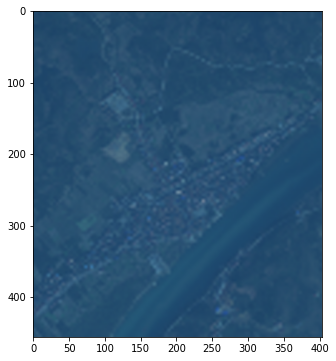

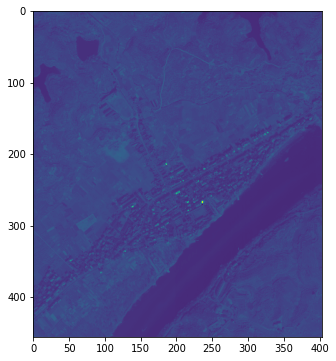

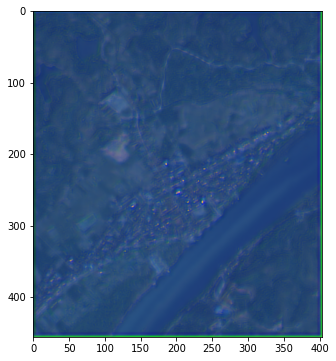

In [6]:
result1 = Image.open('/content/drive/MyDrive/ProjectWork/result/crop8bit_1.PNG')
fused= np.array(result1)
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_1.npy',None)
ms0 = ms[0] 
ms0 = ms0*127.5+127.5
ms0 = ms0.astype('uint8')
ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(ms0)
print(ms0.shape)
pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
plt.figure(figsize=(6,6))
plt.imshow(pan0)
print(ms0.shape)
plt.figure(figsize=(6,6))
plt.imshow(fused)
print(ms0.shape)

WT on ms

In [7]:
# some configuration
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams.update({'font.size':18})

In [8]:

# seperating each band 


In [9]:
lrms_path = '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/lrms'
pan_path = '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/pan'

size  = len(os.listdir(lrms_path)) + 1
for i in range(1,size):
  try:
    pan,ms =  read_img(pan_path, lrms_path, f'crop8bit_{i}.npy',None)
  except:
    continue
  ms0 = ms[0] 
  ms0 = ms0*127.5+127.5
  ms0 = ms0.astype('uint8')
  ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
  # plt.figure(figsize=(6,6))
  # plt.imshow(ms0)

  pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
  # plt.figure(figsize=(6,6))
  # plt.imshow(pan0)
  # print(pan0.shape)
  print(ms0.shape)



(456, 404, 3)
(348, 240, 3)
(268, 276, 3)
(200, 340, 3)
(164, 160, 3)
(556, 416, 3)
(312, 196, 3)
(408, 308, 3)
(304, 312, 3)
(628, 492, 3)
(256, 192, 3)
(360, 312, 3)
(180, 156, 3)
(208, 516, 3)
(484, 496, 3)
(112, 140, 3)
(148, 104, 3)
(304, 232, 3)
(216, 160, 3)
(92, 92, 3)
(148, 140, 3)
(124, 236, 3)
(144, 204, 3)
(216, 224, 3)
(204, 156, 3)


In [10]:
pan0.shape,ms0.shape


((204, 156), (204, 156, 3))

In [11]:
lrms_path = '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/lrms'
pan_path = '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/pan'
size  = len(os.listdir(lrms_path)) + 1
for i in range(1,size):
  try:
    pan,ms =  read_img(pan_path, lrms_path, f'crop8bit_{i}.npy',None)
  except:
    continue
  
  
  ms0 = ms[0] 
  ms0 = ms0*127.5+127.5
  ms0 = ms0.astype('uint8')
  ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
  # plt.figure(figsize=(6,6))
  # plt.imshow(ms0)


  # plt.figure(figsize=(6,6))

  # plt.imshow(pan0)
  # print(pan0.shape)
  print(ms0.shape)
  n = 1
  w = 'db5'
  r,g,b = [c.T for c in ms0.T]
  coeffsR = pywt.wavedec2(r,wavelet=w,level=n,mode='smooth')
  cR = coeffsR.copy()
  # normalize each coefficient Array
  coeffsR[0] /= np.abs(coeffsR[0]).max()
  for detail_level in range(n):
    coeffsR[detail_level + 1] = [d/np.abs(d).max() for d in coeffsR[detail_level]]

  # plt.imshow(coeffsR[0], cmap='Reds')
  # plt.show()
  # plt.imshow(coeffsR[1], cmap='Reds')
  # plt.show()

  coeffsG = pywt.wavedec2(g,wavelet=w,level=n)
  cG = coeffsG.copy()
  coeffsG[0] /= np.abs(coeffsG[0]).max()
  for detail_level in range(n):
      coeffsG[detail_level + 1] = [d/np.abs(d).max() for d in coeffsG[detail_level]]
  # plt.imshow(coeffsG[0],cmap='Greens')
  # plt.show()
  # plt.imshow(coeffsG[1],cmap='Greens')
  # plt.show()

  coeffsB = pywt.wavedec2(g,wavelet=w,level=n)
  cB = coeffsB.copy()
  coeffsB[0] /= np.abs(coeffsB[0]).max()
  for detail_level in range(n):
      coeffsB[detail_level + 1] = [d/np.abs(d).max() for d in coeffsB[detail_level]]
  #plt.imshow(coeffsB[0])
  #plt.show()
  #plt.imshow(coeffsB[1])
  #plt.show()

  lowMS = (np.dstack((coeffsR[0],coeffsG[0],coeffsB[0]))*255.999).astype(np.uint8)
  hiMS = (np.dstack((coeffsR[-1],coeffsG[-1],coeffsB[-1]))*255.999).astype(np.uint8)
  print(lowMS.shape)
  print(hiMS.shape)
  plt.imshow(hiMS)
  plt.show()
  plt.imshow(lowMS)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
size  = len(os.listdir(lrms_path)) + 1
for i in range(1,size):
  try:
    ms0 = cv2.cvtColor(ms0, cv2.COLOR_BGR2GRAY)
    
  except:
    continue



In [13]:
for i in range(1,size):
  print(ms0.shape)

(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)


In [14]:
for i in range(1,size):
  print(pan0.shape)

(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)
(204, 156)


In [15]:
for i in range(1,size):
  print(hiMS.shape, lowMS.shape)

(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)
(106, 82, 3) (106, 82, 3)


In [16]:
for i in range(1,size):
   try:
    hiMS = cv2.cvtColor(hiMS, cv2.COLOR_BGR2GRAY)
    
   except:
    continue
  


In [17]:
for i in range(1,size):
   try:
    lowMS = cv2.cvtColor(lowMS, cv2.COLOR_BGR2GRAY)
    
   except:
    continue
  


In [18]:
for i in range(1,size):
  print(hiMS.shape, lowMS.shape)

(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)
(106, 82) (106, 82)


WT on pan

In [19]:
# Load image
lrms_path = '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/lrms'
pan_path = '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/pan'
size  = len(os.listdir(pan_path)) + 1
n = 1
w = 'db5'
for i in range(1,size):
  try:
    save_name = f'crop8bit_{i}.png'
    pan,ms =  read_img(pan_path, lrms_path, f'crop8bit_{i}.npy',None)
    ms0 = ms[0] 
    ms0 = ms0*127.5+127.5
    ms0 = ms0.astype('uint8')
    ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
    print(pan.shape)
    pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
    original = pan0
    r,g,b = [c.T for c in ms0.T]
    coeffsR = pywt.wavedec2(r,wavelet=w,level=n,mode='smooth')
    cR = coeffsR.copy()
    coeffsR[0] /= np.abs(coeffsR[0]).max()
    for detail_level in range(n):
      coeffsR[detail_level + 1] = [d/np.abs(d).max() for d in coeffsR[detail_level]]
    coeffsG = pywt.wavedec2(g,wavelet=w,level=n)
    cG = coeffsG.copy()
    coeffsG[0] /= np.abs(coeffsG[0]).max()
    for detail_level in range(n):
        coeffsG[detail_level + 1] = [d/np.abs(d).max() for d in coeffsG[detail_level]]
    # plt.imshow(coeffsG[0],cmap='Greens')
    # plt.show()
    # plt.imshow(coeffsG[1],cmap='Greens')
    # plt.show()

    coeffsB = pywt.wavedec2(g,wavelet=w,level=n)
    cB = coeffsB.copy()
    coeffsB[0] /= np.abs(coeffsB[0]).max()
    for detail_level in range(n):
        coeffsB[detail_level + 1] = [d/np.abs(d).max() for d in coeffsB[detail_level]]
    #plt.imshow(coeffsB[0])
    #plt.show()
    #plt.imshow(coeffsB[1])
    #plt.show()

    lowMS = (np.dstack((coeffsR[0],coeffsG[0],coeffsB[0]))*255.999).astype(np.uint8)
    hiMS = (np.dstack((coeffsR[-1],coeffsG[-1],coeffsB[-1]))*255.999).astype(np.uint8)

    # Wavelet transform of image, and plot approximation and details
    titles = ['Approximation', ' Horizontal detail','Vertical detail', 'Diagonal detail']
    coeffs2 = pywt.dwt2(original, w)
    LL, (LH, HL, HH) = coeffs2
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()
  except Exception as e:
    print(e)
    continue


Output hidden; open in https://colab.research.google.com to view.

In [22]:
lrms_path = '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/lrms'
pan_path = '/content/drive/MyDrive/ProjectWork/data/test_gt_gf/pan'
size  = len(os.listdir(pan_path)) + 1
n = 1
w = 'db8'
for i in range(1,size):
  try:
    save_name = f'crop8bit_{i}'
    pan,ms =  read_img(pan_path, lrms_path, f'crop8bit_{i}.npy',None)
    # print(pan.shape)
    pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
    original = pan0

    ms0 = ms[0] 
    ms0 = ms0*127.5+127.5
    ms0 = ms0.astype('uint8')
    ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
    
    r,g,b = [c.T for c in ms0.T]
    coeffsR = pywt.wavedec2(r,wavelet=w,level=n,mode='smooth')
    cR = coeffsR.copy()
    coeffsR[0] /= np.abs(coeffsR[0]).max()
    for detail_level in range(n):
      coeffsR[detail_level + 1] = [d/np.abs(d).max() for d in coeffsR[detail_level]]
    coeffsG = pywt.wavedec2(g,wavelet=w,level=n)
    cG = coeffsG.copy()
    coeffsG[0] /= np.abs(coeffsG[0]).max()
    for detail_level in range(n):
        coeffsG[detail_level + 1] = [d/np.abs(d).max() for d in coeffsG[detail_level]]
    coeffsB = pywt.wavedec2(g,wavelet=w,level=n)
    cB = coeffsB.copy()
    coeffsB[0] /= np.abs(coeffsB[0]).max()
    for detail_level in range(n):
        coeffsB[detail_level + 1] = [d/np.abs(d).max() for d in coeffsB[detail_level]]
    lowMS = (np.dstack((coeffsR[0],coeffsG[0],coeffsB[0]))*255.999).astype(np.uint8)
    hiMS = (np.dstack((coeffsR[-1],coeffsG[-1],coeffsB[-1]))*255.999).astype(np.uint8)
    
    
    # Wavelet transform of image, and plot approximation and details
    titles = ['Approximation', ' Horizontal detail',          'Vertical detail', 'Diagonal detail']
    coeffs2 = pywt.dwt2(original, w)
    LL, (LH, HL, HH) = coeffs2
    fig = plt.figure(figsize=(12, 3))
    for j, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(1, 4, j + 1)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[j], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.show()

    hiMS = cv2.cvtColor(hiMS, cv2.COLOR_BGR2GRAY)
    lowMS = cv2.cvtColor(lowMS, cv2.COLOR_BGR2GRAY)
    
    low_coeff= np.maximum( LH, HL, HH)
    plt.imshow(low_coeff, cmap= 'gray')
    high_fused_array= np.maximum(hiMS,LL)
    
    low_fused_array= np.maximum(lowMS,low_coeff)
    print("=>",high_fused_array.shape, low_fused_array.shape)
    A = pywt.idwt(high_fused_array, None, 'db8', )
    D = pywt.idwt(low_fused_array, None, 'db8',)
    A = cv2.resize(A,high_fused_array.shape[::-1])    
    D = cv2.resize(D,high_fused_array.shape[::-1])    
    fused= A + D
    titles = ['Low Coeff', ' High Coeff','A','D','IDWT']
    # print(fused.shape,"fused shape", A.shape, D.shape)
    fig = plt.figure(figsize=(12, 5))
    for j, a in enumerate([low_fused_array,high_fused_array, A,D,fused]):
        print(a.shape,titles[j])
        ax = fig.add_subplot(1, 5, j + 1)
        ax.imshow(a, interpolation="nearest")
        ax.set_title(titles[j], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    np.save(save_name,fused)
    fig.tight_layout()
    plt.show()
    # outs = cv2.imwrite(f"idwt_{i}.png",D)
    entropy_p = skimage.measure.shannon_entropy(pan0)
    print("Entropy_pan", entropy_p)
    entropy_ms = skimage.measure.shannon_entropy(ms0)
    print("Entropy_ms", entropy_ms)
    entropy_f = skimage.measure.shannon_entropy(fused)
    print("Entropy_fused", entropy_f)

    print("MS STD", ms0.std())
    print("PAN STD", pan0.std())
    print("FINAL STD",fused.std())
    print(f"{'='*12}{i} {j}")
    
  except Exception as e:
    print(e)
    



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(1,size):
  print(fused.size, ms.size, pan.size)


9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824
9265 127296 31824


In [ ]:
os.listdir()

['PanGan_2.py',
 'ops.py',
 'README.md',
 'hist_match.m',
 'compute_res.py',
 'PanGan.py',
 'pan_2_512.mat',
 'ms_2_512.mat',
 'ms_2_512.pkl',
 'pan_2_512.pkl',
 'task1.ipynb',
 'roughexp.ipynb',
 'DWT.ipynb',
 'testexprgb.ipynb',
 'Untitled1.ipynb',
 'Untitled2.ipynb',
 'image2.ipynb',
 'image3.ipynb',
 'SampleGAN.ipynb',
 'data',
 'DataSet.py',
 'train.py',
 'test2.py',
 'result',
 'config.py',
 '__pycache__',
 'log_06_02-generator',
 'model_06_02-generator',
 'ms0.tif',
 'parameters.ipynb',
 'xideapetrovic.py',
 'image1.ipynb',
 'samplePhase1.ipynb',
 'Phase1.ipynb',
 'PanGan_b.py',
 'train_pf.py',
 'crop8bit_1.npy',
 'crop8bit_2.npy',
 'crop8bit_3.npy',
 'crop8bit_4.npy',
 'crop8bit_5.npy',
 'crop8bit_6.npy',
 'crop8bit_7.npy',
 'crop8bit_8.npy',
 'crop8bit_9.npy',
 'crop8bit_10.npy',
 'crop8bit_11.npy',
 'crop8bit_12.npy',
 'crop8bit_13.npy',
 'crop8bit_14.npy',
 'crop8bit_15.npy',
 'crop8bit_16.npy',
 'crop8bit_17.npy',
 'crop8bit_18.npy',
 'crop8bit_19.npy',
 'crop8bit_20.npy',


In [ ]:
read8bit('idwt_2.tiff','idwt')

FileNotFoundError: ignored

In [ ]:
for i in range(1,size):
  entropy = skimage.measure.shannon_entropy(pan0)
  print(entropy)



In [ ]:
entropy = skimage.measure.shannon_entropy(ms0)
print(entropy)

In [ ]:
entropy = skimage.measure.shannon_entropy(fused)
print(entropy)

In [ ]:
print("MS STD", ms0.std())
print("PAN STD", pan0.std())
print("FINAL STD",fused.std())

In [ ]:
import math
import numpy as np
import cv2

def ssim(ms0, fused):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    m = ms0.astype(np.float64)
    f = fused.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(m, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(f, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(m**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(f**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(m * f, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(m, f):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not m.shape == f.shape:
        raise ValueError('Input images must have the same dimensions.')
    if m.ndim == 2:
        return ssim(m, f)
    elif m.ndim == 3:
        if m.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(m, f))
            return np.array(ssims).mean()
        elif m.shape[2] == 1:
            return ssim(np.squeeze(m), np.squeeze(f))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
ssim(ms0,fused)

In [ ]:
scc(pan0,fused)

In [ ]:
scc(ms0,fused)

Mutual information

In [ ]:
hist_2d, x_edges, y_edges = np.histogram2d( ms0.ravel(),fused.ravel(),bins=20)
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

In [ ]:
import pywt
import cv2
import numpy as np

# This function does the coefficient fusing according to the fusion method
def fuseCoeff(ms0, pan0, method):

    if (method == 'mean'):
        cooef = (ms0 + pan0) / 2
    elif (method == 'min'):
        cooef = np.minimum(ms0,pan0)
    elif (method == 'max'):
        cooef = np.maximum(ms0,pan0)
    else:
        cooef = []

    return cooef


# Params
FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory
# Read the two image
I1 = cv2.imread('i1.bmp',0)
I2 = cv2.imread('i2.jpg',0)

# We need to have both images the same size
I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

## Fusion algo

# First: Do wavelet transform on each image
wavelet = 'db1'
ms0 = pywt.wavedec2(I1[:,:], wavelet)
pan0 = pywt.wavedec2(I2[:,:], wavelet)

# Second: for each level in both image do the fusion according to the desire option
fusedCooef = []
for i in range(len(ms0)-1):

    # The first values in each decomposition is the apprximation values of the top level if(i == 0):

        fusedCooef.append(fuseCoeff(ms0[0],pan0[0],FUSION_METHOD))
      else:

        # For the rest of the levels we have tupels with 3 coeeficents
        c1 = fuseCoeff(ms0[i][0],pan0[i][0],FUSION_METHOD)
        c2 = fuseCoeff(ms0[i][1], pan0[i][1], FUSION_METHOD)
        c3 = fuseCoeff(ms0[i][2],pan0[i][2], FUSION_METHOD)

        fusedCooef.append((c1,c2,c3))

# Third: After we fused the cooefficent we nned to transfor back to get the image
fusedImage = pywt.waverec2(fusedCooef, wavelet)

# Forth: normmalize values to be in uint8
fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
fusedImage = fusedImage.astype(np.uint8)

# Fith: Show image
cv2.imshow("win",fusedImage)

In [ ]:
cv2.imwrite?